<a href="https://colab.research.google.com/github/kim-jeonghyun/advanced_detection_segmentation_model/blob/1-inference-with-sam/ko/SAM_inference_with_custom_images_ko.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segment Anything Model Inference for Block Images using `transformers` 🤗 library

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1VWB53jTGn50oTTHu3mWkBnDGxpJj8CAA#scrollTo=88-pHGZxdi4z) [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/kim-jeonghyun/advanced_detection_segmentation_model)


### Overview
prompt 와 이미지 정보를 받아서 mask prediction을 Output으로 내놓는 Segment Anything을 활용하여 사람과 반복적 object(체스)가 있는 이미지를 '추가 학습 없이' 추론해보는 노트북.  
facebookresearch 레포의 코드를 설치해 사용한 [segment_anything_inference_practice_ko.ipynb](https://colab.research.google.com/drive/1VWB53jTGn50oTTHu3mWkBnDGxpJj8CAA#scrollTo=88-pHGZxdi4z) 노트북과는 달리 HuggingFace transformers 라이브러리를 활용합니다. FacebookResearch
SAM 모델을 활용하여 이미지 전체를 semantic segmentation하는 것이 아니라 특정 object를 인식하여 mask를 추론하기 원한다면, prompt가 이미지와 함께 input으로 들어가야 하고, facebook research게 공개한 모델은 pixel point 또는 bbox 정보만을 prompt로 받아 처리해준다.  
따라서 Ground Truth로 bbox와 라벨이 제공되는 데이터에서 segmentation mask를 추가로 얻기 위해 사용하거나,
먼저 Object Detector 모델을 사용해 먼저 target object인 bbox를 추론하고, 그 뒤에 SAM을 붙이는 방법을 사용할 수 있다. 이 노트북은 전자로 Mannual Annotation을 사용하여 완성한 데이터셋으로 mask prediction만 수행하였음  

label : ['chess', 'hand']  
dataset style : coco

작성자 : [김정현](kimjeonghyun.jkim@gmail.com)   
작성일 : 2023.11.13   


### 참고
[Segment Anything Model](https://ai.facebook.com/research/publications/segment-anything)   
[Official Github](https://github.com/facebookresearch/segment-anything)  
[Facebook Official Inference Example](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb)  
[Original Notebook of HuggingFace](https://github.com/huggingface/notebooks/blob/main/examples/segment_anything.ipynb)
  

## Step 0. Set-up environment

In [1]:
# 스펙 확인
!pwd
!python --version
!cat /etc/issue
import torch, torchvision

print(torch.__version__, torch.cuda.is_available())

/content
Python 3.10.12
Ubuntu 22.04.3 LTS \n \l

2.1.0+cu121 True


In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Install 🤗 Transformers and 🤗 Datasets.  
4.37.2 버전에서 테스트 되었으며, 4.38.1 버전에서 SamModel에 에러가 발생하는 것으로 확인되여 오피셜 레포가 아닌 pip 를 통해 설치해서 진행해 보겠음

In [3]:
# !pip install -q git+https://github.com/huggingface/transformers.git
!pip install -q datasets

In [7]:
!pip install transformers==4.37.2

  Using cached transformers-4.37.2-py3-none-any.whl (8.4 MB)
  Attempting uninstall: transformers
    Found existing installation: transformers 4.39.0.dev0
    Uninstalling transformers-4.39.0.dev0:
      Successfully uninstalled transformers-4.39.0.dev0


## Utility functions

Run the cells below to import the needed utility functions for displaying the masks!

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

def transform_bbox(bx_lst):
  """[x1,x2, w, h] 형식의 box 좌표를 [x1, y1, x2, y2]으로 변형하는 함수"""
  return [round(bx_lst[0],2), round(bx_lst[1],2), round(bx_lst[0]+bx_lst[2],2), round(bx_lst[1]+bx_lst[3],2)]

def transform_list(original_list):
  """(1, m, n) 구조의 리스트를 (m, 1, n)구조로 바꾸는 함수"""
  return [[item] for item in original_list[0]]

def get_boxlabel_from_image(img_path, anno):
  """이미지 경로와 coco 어노테이션 스타일의 JSON 파일을 넣으면 해당 이미지의 어노테이션 바운딩 박스와 라벨을 리스트로 반환하는 함수"""
  img_hash_table = {d['file_name']: d for d in anno['images']}
  img_id = img_hash_table['/'.join(img_path.split('/')[-2:])]['id']

  # 각 어노테이션에 대한 바운딩 박스와 라벨 정보를 저장하는 리스트 생성
  anno_list = [{'bbox': d['bbox'], 'label': d['category_id']} for d in anno['annotations'] if d['image_id'] == img_id]

  return anno_list

def get_point_from_bbox(bbox):
  """bbox 좌표가 [x1, y1, w, h] 형식의 리스트임"""
  return [round((2*bbox[0]+ bbox[2])/2, 2), round((2*bbox[1]+ bbox[3])/2, 2)]

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def show_all_masks_on_image(raw_image, all_masks, scores):
    num_points = len(all_masks)  # 포인트의 수
    num_masks_per_point = all_masks[0].shape[0]  # 각 포인트별 마스크 수

    # 전체 서브플롯의 크기 설정 (포인트 수 x 각 포인트별 마스크 수)
    fig, axes = plt.subplots(num_points, num_masks_per_point, figsize=(15, 15))

    for point_idx, masks in enumerate(all_masks):
        for mask_idx, mask in enumerate(masks):
            ax = axes[point_idx, mask_idx]  # 해당 서브플롯 찾기
            mask = mask.cpu().detach()
            score = scores[0][point_idx, mask_idx].item()

            ax.imshow(np.array(raw_image))
            show_mask(mask, ax)
            ax.title.set_text(f"Mask {mask_idx+1}, Score: {score:.3f}")
            ax.axis("off")

    plt.show()

## Step 1. Load Model

Use the `from_pretrained` method on the `SamForMaskGeneration` class to load the model from the Hub! For the sake of this demonstration we will use the `vit-huge` checkpoint.

In [8]:
import torch
from transformers import SamModel, SamProcessor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

## Step 2. Prediction Practice

Let's deeply dive into how you can run different type of predictions, given different inputs. You will see how to

- Generate segmentation masks given a 2D localization
- Generate segmentation masks per given localization (one prediction per 2D point)
- Generate segmentation masks given a bounding box
- Generate segmentation masks given a bounding box and a 2D points
- Generate segmentat

### 2-1. Load the example image

In [10]:
from google.colab import files
import os

uploaded = files.upload()
# 특정 파일 타입만 업로드하고 싶은

Saving playing_chess.jpg to playing_chess (1).jpg


In [13]:
[filename for filename in uploaded.keys()]

['playing_chess (1).jpg']

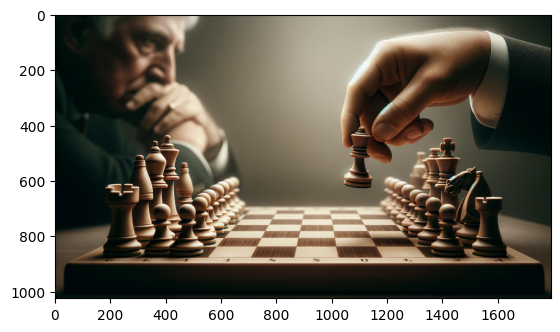

In [15]:
from PIL import Image
import requests
import matplotlib.pyplot as plt

img_path = 'playing_chess.jpg'
raw_image = Image.open(img_path).convert("RGB")

plt.imshow(raw_image)

### 2-2. Retrieve the image embeddings

In order to avoid computing multiple times the same image embeddings, we will compute it only once, and use these embeddings to directly feed them to the model for faster inference

In [16]:
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

In [18]:
image_embeddings.size()

torch.Size([1, 256, 64, 64])

### 2-3. Automatic mask generation

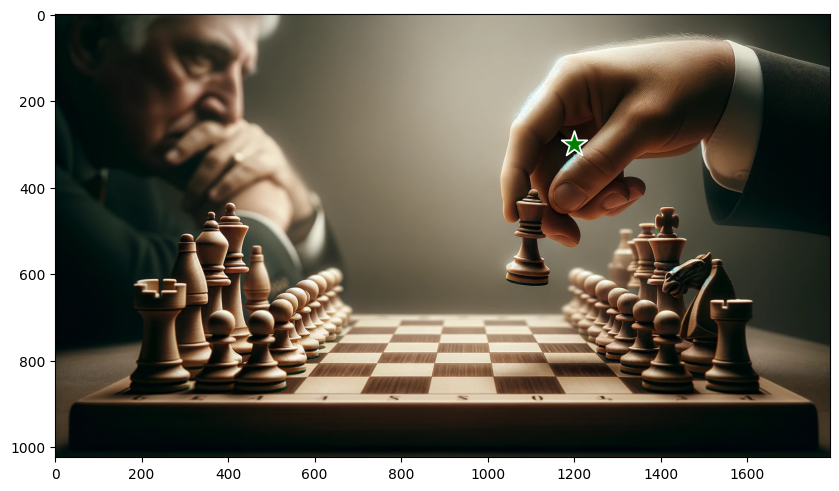

In [34]:
input_points = [[[1200, 300]]]
show_points_on_image(raw_image, input_points[0])


In [36]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)


In [37]:
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

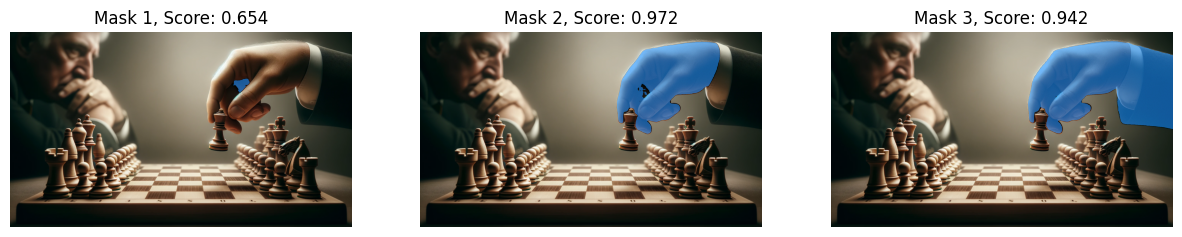

In [38]:
show_masks_on_image(raw_image, masks[0], scores)

2-3. Get annotation

coco style로 만들어진 데이터셋이라서 annotation json 파일을 로드하고, 해당 file_name의 image_id에 해당하는 annotation 정보를 가져와야 한다.


In [ ]:
import json

with open('/content/drive/MyDrive/Colab Notebooks/block_bboxes/annotations/instances_default.json', 'r') as f:
  anno = json.load(f)

In [ ]:
anno['annotations'][0]

In [ ]:
anno_lst = get_boxlabel_from_image(img_path, anno)

In [ ]:
anno_lst

## Usecase 1: Feed a set of 2D points to predict a mask

Let's first focus on the first classic usecase of SAM. You can feed the model a set of 2D points to predict a segmentation mask. The more you provide 2D points, the better the resulting mask will be.

In this example, let's try to predict the mask that corresponds to the top left window of the parked car.

The input points needs to be in the format:

`nb_images, nb_predictions, nb_points_per_mask, 2`

With SAM you can either predict a single prediction given multiple points, or a prediction per point. This is denoted by `nb_predictions` dimension. We will see in the next sections how to perform this type of prediction

bbox 좌표만 있기 때문에 이를 활용하여 single_point를 추출한다.

In [ ]:
anno_lst[0]['bbox']

In [ ]:
sample_point = get_point_from_bbox(anno_lst[0]['bbox'])

In [ ]:
input_points = [[sample_point]]
show_points_on_image(raw_image, input_points[0])

For that, simply pass the raw image, the points




In [ ]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)

As you can see, the predicted masks are sorted in their IoU score order. The first mask indeed seems to correspond to the mask of the top right window of the parked car.

You can also feed a set of points to predict a single mask. Let's try to predict a mask, given two points

In [ ]:
multiple_points = [get_point_from_bbox(bbox) for bbox in [anno['bbox'] for anno in anno_lst] ]

테스트 해보니까 멀티플 포인트라고 했지만, 2개 이상 넣으면 에러 발생

In [ ]:
input_points = [multiple_points[:2]]
show_points_on_image(raw_image, input_points)

2개의 점을 활용해 각각의 마스크를 뽑는게 아니라 2개의 점이 포함된 하나의 마스크를 찾으려고 하는 느낌

In [ ]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)

## Usecase 2: Predict segmentations masks using bounding boxes

It is possible to feed bounding boxes to the model to predict segmentation masks of the object of interest in that region.

The bounding box needs to be a list of points, corresponding to the flattened coordinates of the top left point, and bottom right point of the bounding box. Let's look at an example below

coco는 [x1,x2, w, h] 형식이고, sam은 [x1, y1, x2, y2] 형식이라 변환 과정을 거쳐야 함

In [ ]:
input_boxes = [transform_bbox(b) for b in [anno['bbox']for anno in anno_lst]]

In [ ]:
sample_bbox = input_boxes[0]

In [ ]:
show_boxes_on_image(raw_image, [sample_bbox])

bbox로 segmenatation하기

In [ ]:
inputs = processor(raw_image, input_boxes=[[sample_bbox]], return_tensors="pt").to(device)
inputs["input_boxes"].shape

In [ ]:
# 원래 있던 픽셀 밸류가 아닌 아까 구한 image_embeddings를 input으로 넣을 것
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})
inputs.keys()

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [ ]:
show_masks_on_image(raw_image, masks[0], scores)

point prompt는 2개의 point로 하나의 segmentation prediction을 얻는 게 가능했지만, bbox의 경우는 복수의 bbox로 하나의 prediction을 얻을 수는 없음  
복수의 박스를 input으로 넣을 땐 각각의 prediction을 얻을 때이고, 단, point와 bbox를 넣어서 하나의 prediction을 얻게 할 수는 있음

## Usecase 3: Predict segmentation masks given points and bounding boxes

In [ ]:
show_points_and_boxes_on_image(raw_image, [sample_bbox], [sample_point])

In [ ]:
inputs = processor(raw_image, input_boxes=[[sample_bbox]], input_points=[[sample_point]], return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [ ]:
masks[0].shape

In [ ]:
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

point에 라벨을 붙여서 그 부분의 region을 out할 지 말지를 알려줄 수도 있다.

You can also pass points with a label to segment out that region. Let us have a deeper look below

In [ ]:
# 예시 visualization을 위해서 원래 bboxes[0]보다 약간 크게 프레이밍
test_boxes = [[[319,400, 450, 528], input_boxes[1]]]
test_boxes

In [ ]:
labels = [0, 1]

show_points_and_boxes_on_image(raw_image, test_boxes[0], input_points[0], labels)

아래의 점 2에서 1번째 점은 out, 2번째 점은 in

In [ ]:
len(test_boxes), len(input_points), len(labels)

In [ ]:
#test_boxes = [[[319, 400, 450, 528]]]
input_points = [[[382.54, 476.27]], [[896.34, 616.77]]]

In [ ]:
inputs = processor(raw_image, input_boxes=[test_boxes], input_points=[input_points], input_labels=[labels], return_tensors="pt").to(device)

inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [ ]:
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

In [ ]:
show_masks_on_image(raw_image, masks[0][1], scores[:, 0, :])

bbox 안에서 label 0을 받은 point를 제외한 segmentation을 예측한다.

## Usecase 4: Predict multiple masks per image

한 이미지에 마스크 여러 개를 예측하고 싶다면,

- `nb_predictions` dimension에 여러 개 점을 prompt로 넣는다.
- 같은 이미지에 여러 개의 bbox를 Prompt로 준다.

In [ ]:
mulitple_points = [get_point_from_bbox(anno['bbox']) for anno in anno_lst]

In [ ]:
show_points_on_image(raw_image, mulitple_points)

### Sub-usecase 1: one prediction per point

(1, m, 2) 구조의 리스트를 input으로 집어 넣으면, 2개의 점을 넣어도 하나의 prediction을 output하도록 추정하게 된다. 점 하나 마다 하나의 predictiond을 하도록 하려면, input points_list의 구조를 (m, 1, 2)로 바꿔서 인풋으로 넣으면 된다.

In [ ]:
input_points_2 = transform_list([multiple_points])

In [ ]:
input_points_2

In [ ]:
[multiple_points]

In [ ]:
np.array([multiple_points]).shape

In [ ]:
np.array(input_points_2).shape

In [ ]:
input_points_2

In order to add the desired dimension, and pass it to the `SamProcessor`

In [ ]:
inputs = processor(raw_image, input_points=[input_points_2], return_tensors="pt").to(device)
inputs["input_points"].shape

In [ ]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

Let's print the shapes of the output to understand better what is going on

In [ ]:
scores.shape

In [ ]:
scores[0]

Here the first dimension corresponds to the image batch size, the second dimension corresponds to the `nb_predictions` dimension. And the last dimension is the number of predicted masks **per prediction** , and it is set to 3 by default according to the official implementation

In [ ]:
show_all_masks_on_image(raw_image, masks[0], scores)

In [ ]:
show_masks_on_image(raw_image, masks[0][0], scores[:, 0, :])

In [ ]:
show_masks_on_image(raw_image, masks[0][1], scores[:, 0, :])

### Sub-usecase 2: Feed multiple bounding boxes to the same image

In [ ]:
input_boxes

In [ ]:
show_boxes_on_image(raw_image, input_boxes)

Just pass the input boxes as follows, to match the convention of the processor

In [ ]:
inputs = processor(raw_image, input_boxes=[input_boxes], return_tensors="pt").to(device)
inputs["input_boxes"].shape

This time, let's just output a single mask per box, for that we can just pass `multimask_output=False` in the forward pass

In [ ]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [ ]:
scores.shape

bbox 마다 하나씩 모든 segmentation prediction을 얻었음



In [ ]:
show_masks_on_image(raw_image, masks[0], scores)

## Usecase 5: 라벨마다 따로 받기  

현재 예시에서 사용한 데이터는 라벨이 크게 '블록'과 '손'으로 2개이다. 따로 따로 집어놓고 마스크를 저장하면 마스크 정보도 라벨별로 저장이 가능할 것

In [ ]:
# 각 라벨별로 따로 bbox 모으기
# 라벨별로 bbox 좌표들을 모으기
label_dict = {}
for item in anno_lst:
    label = item['label']
    bbox = item['bbox']
    if label not in label_dict:
        label_dict[label] = []
    label_dict[label].append(transform_bbox(bbox))

label_dict

In [ ]:
num_labels = label_dict.keys()
num_labels

In [ ]:
[[319.83, 424.72, 445.26, 527.82],
 [828.87, 549.34, 963.8, 684.2],
 [812.1, 317.34, 889.42, 401.53],
 [425.95, 530.44, 550.52, 654.1],
 [318.11, 402.39, 452.99, 474.55],
 [534.63, 546.74, 659.2, 670.4],
 [315.53, 522.66, 428.93, 634.35]]

In [ ]:
label_dict[1]

In [ ]:
show_boxes_on_image(raw_image, label_dict[1])

In [ ]:
inputs = processor(raw_image, input_boxes=[label_dict[1]], return_tensors="pt").to(device)
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks[0], scores)

In [ ]:
inputs = processor(raw_image, input_boxes=[label_dict[2]], return_tensors="pt").to(device)
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs, multimask_output=False)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores
show_masks_on_image(raw_image, masks[0], scores)